In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import os

from utils import *
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchviz import make_dot, make_dot_from_trace

In [2]:
torch.manual_seed(37)
np.random.seed(37)

plt.rcParams["figure.figsize"] = (7, 7)
torch.autograd.set_detect_anomaly(True)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [3]:
class SumMNISTDataset(Dataset):
    def __init__(self, root, blanks, sum_digit, size, transforms):
        path = os.path.join(root, "train")
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        images = load_images(image_path)
        labels = load_labels(label_path)

        # add_blank(images, labels, blanks)
        self.images, self.labels = sum_dataset(images, labels, size, sum_digit)
        self.sum_digit = sum_digit
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]

        images = torch.tensor(images, dtype=torch.float).reshape(
            self.sum_digit, 1, 28, 28
        )
        labels = torch.tensor(labels, dtype=torch.int)

        if self.transforms:
            images = self.transforms(images)

        return images, labels

In [4]:
batch_size = 128
digit_num = 2
label_num = 9 * digit_num + 1
each_comb_size = 1200
root = r"C:\Users\trand\longg\code\python\deep learning\mnist\pytorch"


dataset = SumMNISTDataset(
    root + "\mnist",
    0,
    digit_num,
    each_comb_size,
    transforms.Compose([transforms.Grayscale(), transforms.Normalize(127.5, 127.5)]),
)

data_size = len(dataset)
print(data_size)

dataloader = DataLoader(dataset, batch_size, True, drop_last=True)

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\trand\AppData\Local\Temp\ipykernel_5492\2839878299.py:9: SyntaxWarning: invalid escape sequence '\m'
  root + "\mnist",


120000


In [5]:
def plot_data(data, row, col):
    images, labels = data
    digit_num = images.shape[1]

    fig, axes = plt.subplots(row, col * (digit_num + 1), figsize=(15, row))
    data_acc = 0
    i = 0

    axes = axes.flatten()
    for a, ax in enumerate(axes):
        if i < digit_num:
            ax.imshow(images[data_acc][i], cmap="gray")
            i += 1
        else:
            ax.text(
                0.5,
                0.5,
                labels[data_acc],
                fontsize=150 / (row * col),
                ha="center",  # Horizontal alignment: center
                va="center",  # Vertical alignment: center
                transform=ax.transAxes,
            )  # Use axis coordinates (0 to 1)
            data_acc += 1
            i = 0
        ax.axis("off")

    fig.tight_layout()

1.0


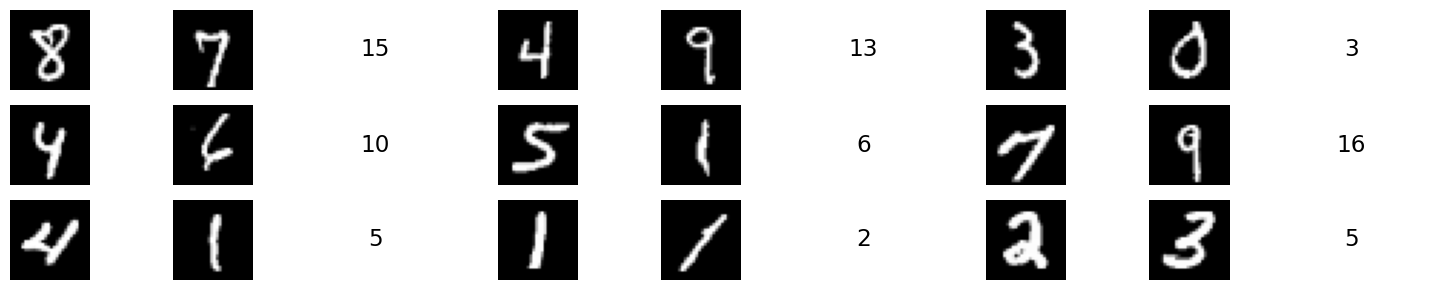

In [6]:
images_view, labels_view = next(iter(dataloader))[:9]
images_view = images_view.detach().numpy()
images_view = np.transpose(images_view, axes=(0, 1, 3, 4, 2))
labels_view = labels_view.numpy()
plot_data((images_view, labels_view), 3, 3)
print(images_view.max())

In [7]:
class Generator(nn.Module):
    def __init__(
        self, latent_dim, hidden_size, num_layers, embed_num, filter_num, bias=False
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed_num = embed_num
        self.latent_dim = latent_dim

        self.lstm = nn.LSTM(
            hidden_size, hidden_size, num_layers, batch_first=True, dropout=0.5
        )

        self.embed = nn.Embedding(label_num, hidden_size)
        self.fc_embed = nn.Linear(hidden_size, 49)

        self.lrelu = nn.LeakyReLU(0.2)
        self.convT1 = nn.ConvTranspose2d(latent_dim, filter_num * 4, 7, 1, 0, bias=bias)
        self.bnorm1 = nn.BatchNorm2d(filter_num * 4)

        self.convT2 = nn.ConvTranspose2d(
            filter_num * 4 + 1, filter_num * 2, 4, 2, 1, bias=bias
        )
        self.bnorm2 = nn.BatchNorm2d(filter_num * 2)

        self.convT3 = nn.ConvTranspose2d(filter_num * 2, filter_num, 4, 2, 1, bias=bias)
        self.bnorm3 = nn.BatchNorm2d(filter_num)

        self.convT4 = nn.ConvTranspose2d(filter_num, 1, 3, 1, 1, bias=bias)

    def forward(self, x, y):
        # x: (batch, digit_num, latent_dim)
        # y: (batch, label_num)

        size = y.shape[0]
        y1 = self.embed(y)
        # y1: (batch, 1, hidden_size)

        y2 = torch.zeros((size, digit_num, self.hidden_size), device=device)
        h = torch.zeros((self.num_layers, size, self.hidden_size), device=device)
        c = torch.zeros((self.num_layers, size, self.hidden_size), device=device)
        lstm_in = y1
        for t in range(digit_num):
            lstm_out, (h, c) = self.lstm(lstm_in, (h, c))
            y2[:, t, :] = lstm_out.squeeze()
            lstm_in = lstm_out.detach()
        # y2: (batch, digit_num, hidden_size)

        ims = torch.zeros((size, digit_num, 1, 28, 28), device=device)
        for t in range(digit_num):
            # preprocessing lstm output
            y3 = self.fc_embed(y2[:, t, :])
            y4 = y3.reshape(size, 1, 7, 7)

            # preprocessing noise
            x2 = x[:, t, :].reshape(size, self.latent_dim, 1, 1)

            # input: (128, latent_dim, 1, 1)
            x3 = self.convT1(x2)
            x4 = self.bnorm1(x3)
            x5 = self.lrelu(x4)
            # output: (128, 128, 7, 7)

            # main part of the generator
            x5_ = torch.concat((x5, y4), dim=1)

            # input: (128, 129, 7, 7)
            x6 = self.convT2(x5_)
            x7 = self.bnorm2(x6)
            x8 = self.lrelu(x7)
            # output: (128, 64, 14, 14)

            x9 = self.convT3(x8)
            x10 = self.bnorm3(x9)
            x11 = self.lrelu(x10)
            # output: (128, 32, 28, 28)

            x12 = self.convT4(x11)
            im = nn.functional.tanh(x12)
            # output: (128, 1, 28, 28)

            ims[:, t, :, :] = im

        return ims

In [8]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size, num_layers, embed_num, filter_num, bias=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.filter_num = filter_num
        self.embed_num = embed_num

        self.embed = nn.Embedding(label_num, embed_num)
        self.fc_embed = nn.Linear(embed_num, 28 * 28)

        self.lrelu = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)

        self.conv1 = nn.Conv2d(2, filter_num, 4, 2, 1, bias=bias)
        self.bnorm1 = nn.BatchNorm2d(filter_num)

        self.conv2 = nn.Conv2d(filter_num, filter_num * 2, 4, 2, 1, bias=bias)
        self.bnorm2 = nn.BatchNorm2d(filter_num * 2)

        # self.conv3 = nn.Conv2d(filter_num * 2, filter_num * 4, 4, 2, 1, bias=bias)
        # self.bnorm3 = nn.BatchNorm2d(filter_num * 4)

        self.lstm = nn.LSTM(
            7 * 7 * filter_num * 2,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=0.5,
        )
        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, x, y):
        size = x.shape[0]

        y1 = self.embed(y)
        y2 = self.fc_embed(y1)
        y3 = y2.reshape(size, 1, 1, 28, 28)
        y4 = y3.expand(size, digit_num, 1, 28, 28)
        x_ = torch.concat((x, y4), dim=2)

        # empty tensor for storing convolutional layer output
        feats = torch.zeros(
            (size, digit_num, 7 * 7 * self.filter_num * 2), device=device
        )

        for t in range(digit_num):
            # input: (128, 1, 28, 28)
            x1 = self.conv1(x_[:, t, :, :, :])
            x2 = self.bnorm1(x1)
            x3 = self.lrelu(x2)
            # output: (128, 32, 14, 14)

            x4 = self.conv2(x3)
            x5 = self.bnorm2(x4)
            x6 = self.lrelu(x5)
            # output: (128, 64, 7, 7)

            x7 = self.flatten(x6)
            # output: (128, 64 * 7 * 7)

            feats[:, t, :] = x7

        # initializing initial state
        lstm_out, _ = self.lstm(feats)
        x8 = lstm_out[:, -1, :]

        logits = self.fc1(x8)
        logits1 = self.drop(logits)

        return logits1

In [9]:
latent_dim = 100
hidden_size = 512
embed_num = 50
filter_num = 64
num_layers = 1

learning_rate_G = 0.0002
learning_rate_D = 0.0001
beta_1 = 0.5


def weight_ini(model):
    if (
        type(model) == nn.Linear
        or type(model) == nn.Conv2d
        or type(model) == nn.ConvTranspose2d
    ):
        nn.init.normal_(model.weight.data, 0.0, 0.2)
    elif type(model) == nn.BatchNorm2d:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0.0)


G = (
    Generator(latent_dim, hidden_size, num_layers, embed_num, filter_num)
    .to(device)
    .apply(weight_ini)
)
D = (
    Discriminator(hidden_size, num_layers, embed_num, filter_num)
    .to(device)
    .apply(weight_ini)
)

G_optimizer = optim.Adam(G.parameters(), learning_rate_G, (beta_1, 0.999))
D_optimizer = optim.Adam(D.parameters(), learning_rate_D, (beta_1, 0.999))

criterion = nn.BCEWithLogitsLoss()

c:\Users\trand\.conda\envs\deep_learning\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
def generate_image(epoch, batch, fixed_noise, fixed_label):
    images = G(fixed_noise, fixed_label).cpu().detach().numpy().squeeze()
    labels = fixed_label.cpu().numpy()

    plot_data((images, labels), 2, 2)
    plt.savefig(root + rf"\GAN\LSTMGAN_image\epoch_{epoch + 1}_batch_{batch}.png")
    plt.close()


def generate_fake_sample(size):
    noises = torch.randn((size, digit_num, latent_dim), device=device)
    conditions = torch.randint(0, label_num, (size, 1), device=device)
    images = G(noises, conditions)
    labels = torch.zeros((size, 1), device=device)

    return images, conditions, labels


def generate_real_sample(size):
    images, conditions = next(iter(dataloader))
    labels = torch.ones((size, 1), device=device)

    return images.to(device)[:size], conditions.to(device)[:size], labels

In [11]:
epochs = 10
torch.autograd.set_detect_anomaly(True)


D_losses = []
G_losses = []

fixed_noise = torch.randn((4, digit_num, latent_dim), device=device)
fixed_label = torch.randint(0, label_num, (4, 1), device=device)

half_batch_size = batch_size // 2

for epoch in range(epochs):

    print(f"-- Epoch: {epoch + 1} --")

    for batch in range(data_size // batch_size):
        f_im, f_la, zeros = generate_fake_sample(half_batch_size)
        r_im, r_la, ones = generate_real_sample(half_batch_size)

        #############################
        ##                          ##
        ##  DISCRIMINATOR TRAINING  ##
        ##                          ##
        ##############################

        ###################### Train on Real ######################
        D.zero_grad()
        r_pred = D(r_im, r_la)
        r_loss = criterion(r_pred, ones)
        r_loss.backward()
        D_optimizer.step()
        ###################### Train on Fake ######################
        D.zero_grad()
        f_pred = D(f_im, f_la)
        f_loss = criterion(f_pred, zeros)
        f_loss.backward()
        D_optimizer.step()

        ##########################
        ##                      ##
        ##  GENERATOR TRAINING  ##
        ##                      ##
        ##########################

        G.zero_grad()

        noises = torch.randn((batch_size, digit_num, latent_dim), device=device)
        conditions = torch.randint(0, label_num, (batch_size, 1), device=device)
        ones = torch.ones((batch_size, 1), device=device)
        f_pred = D(G(noises, conditions), conditions)

        g_loss = criterion(f_pred, ones)
        g_loss.backward()
        G_optimizer.step()

        d_loss = (r_loss.item() + f_loss.item()) / 2
        g_loss = g_loss.item()

        D_losses.append(d_loss)
        G_losses.append(g_loss)

        if batch % 200 == 0:
            print(
                f"[Batch: {(batch) * batch_size :7d}/{data_size}]  D_Loss: {d_loss}  G_Loss: {g_loss}"
            )

    generate_image(epoch, batch, fixed_noise, fixed_label)

    checkpoint = {}
    checkpoint["D_model_state"] = D.state_dict()
    checkpoint["G_model_state"] = G.state_dict()
    checkpoint["D_optimizer_state"] = D_optimizer.state_dict()
    checkpoint["G_optimizer_state"] = G_optimizer.state_dict()
    checkpoint["D_losses"] = D_losses
    checkpoint["G_losses"] = G_losses

    torch.save(checkpoint, root + rf"\GAN\LSTMGAN_checkpoint\checkpoint_{epoch + 1}")

-- Epoch: 1 --
[Batch:       0/120000]  D_Loss: 1.9572226107120514  G_Loss: 0.5649222135543823
[Batch:   25600/120000]  D_Loss: 0.6158105731010437  G_Loss: 1.2457051277160645
[Batch:   51200/120000]  D_Loss: 0.48064224421977997  G_Loss: 2.0698819160461426
[Batch:   76800/120000]  D_Loss: 0.3308474123477936  G_Loss: 4.481691360473633
[Batch:  102400/120000]  D_Loss: 0.3027600049972534  G_Loss: 2.3810243606567383
-- Epoch: 2 --
[Batch:       0/120000]  D_Loss: 0.34810711443424225  G_Loss: 2.800050735473633
[Batch:   25600/120000]  D_Loss: 0.38305799663066864  G_Loss: 3.0341742038726807
[Batch:   51200/120000]  D_Loss: 0.3956250250339508  G_Loss: 3.102670907974243
[Batch:   76800/120000]  D_Loss: 0.40866243839263916  G_Loss: 3.3525044918060303
[Batch:  102400/120000]  D_Loss: 0.38925209641456604  G_Loss: 2.850043535232544
-- Epoch: 3 --
[Batch:       0/120000]  D_Loss: 0.36467400193214417  G_Loss: 5.186356067657471
[Batch:   25600/120000]  D_Loss: 0.33033670485019684  G_Loss: 2.3749122619

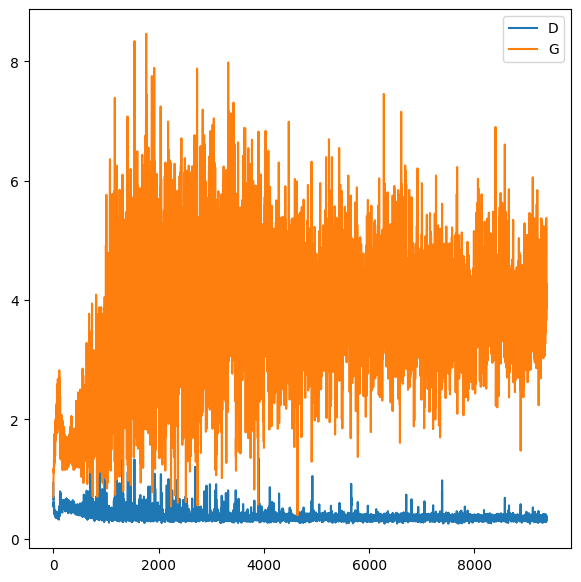

In [ ]:
plt.plot(D_losses, label="D")
plt.plot(G_losses, label="G")
plt.legend()

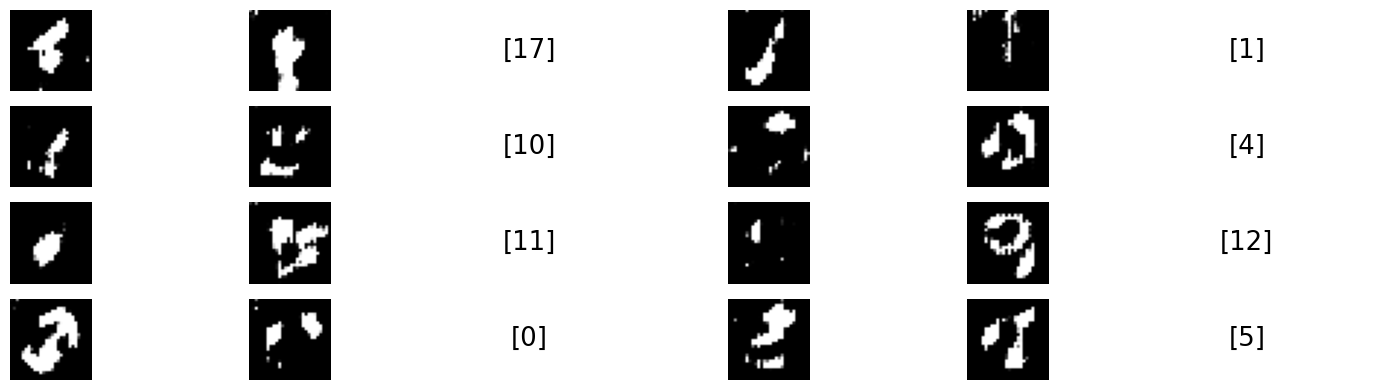

In [ ]:
checkpoint = torch.load(
    r"C:\Users\trand\longg\code\python\deep learning\mnist\pytorch\GAN\LSTMGAN_checkpoint\checkpoint_10"
)
D.load_state_dict(checkpoint["D_model_state"])
D_optimizer.load_state_dict(checkpoint["D_optimizer_state"])
G.load_state_dict(checkpoint["G_model_state"])
G_optimizer.load_state_dict(checkpoint["G_optimizer_state"])

noises_test = torch.randn((8, digit_num, latent_dim), device=device)


labels_test = torch.randint(0, label_num, (8, 1), device=device)


images_test = G(noises_test, labels_test).cpu().detach().numpy().squeeze()


labels_test = labels_test.cpu().numpy()


plot_data((images_test, labels_test), 4, 2)